## 🎯 Objective
Train a Random Forest Classifier for timestomping detection using supervised learning:
1. **Load preprocessed data** from Phase 4
2. **Filter zero-variance features** (VarianceThreshold)
3. **Handle class imbalance** with SMOTE (Synthetic Minority Over-sampling)
4. **Train Random Forest** on balanced training data
5. **Hyperparameter tuning** for optimal performance
6. **Evaluate model** on validation and test sets
7. **Analyze feature importance** for timestomping indicators
8. **Save trained model** for deployment

## 📊 Input Datasets
- **Train:** `data/processed/Phase 4 - Feature Preprocessing/X_train.csv` (1,496,071 records, 27 features)
- **Validation:** `data/processed/Phase 4 - Feature Preprocessing/X_val.csv` (391,550 records, 27 features)
- **Test:** `data/processed/Phase 4 - Feature Preprocessing/X_test.csv` (376,900 records, 27 features)
- **Labels:** `y_train.csv`, `y_val.csv`, `y_test.csv`

## 🔑 Key Concepts

### Why Random Forest Classifier?
- ✅ **Supervised:** Uses labeled data for training (we have 268 labeled examples)
- ✅ **Handles imbalance:** Works with SMOTE for rare anomalies (0.01% of data)
- ✅ **Robust:** Resistant to overfitting with ensemble of decision trees
- ✅ **Interpretable:** Provides feature importance rankings

### Why NOT Isolation Forest?
Initial testing showed Isolation Forest (unsupervised) couldn't distinguish timestomped files because:
- Labeled files had identical timestamp delta patterns (zero variance)
- Only 2/21 features showed good separation (Cohen's d > 0.5)
- Best F1-score: 0.0006 (essentially random guessing)

### Class Imbalance Strategy
- **SMOTE (Synthetic Minority Over-sampling Technique):**
  - Generates synthetic timestomped examples by interpolating between existing ones
  - Balances training data without duplicating exact samples
  - Validation/test sets remain imbalanced (realistic evaluation)

In [79]:
# Cell 2 - Import Libraries
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from datetime import datetime

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.model_selection import GridSearchCV

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")
print(f"Imbalanced-learn version: {__import__('imblearn').__version__}")

✅ Libraries imported successfully
Scikit-learn version: 1.7.2
Imbalanced-learn version: 0.14.0


## 📂 Step 1: Load Preprocessed Data from Phase 4

Loading the train/validation/test splits created in Phase 4.

In [80]:
# Cell 4 - Load Preprocessed Data
# Define paths
data_dir = 'data/processed/Phase 4 - Feature Preprocessing'

# Load training data
print("Loading training data...")
X_train = pd.read_csv(f'{data_dir}/X_train.csv')
y_train = pd.read_csv(f'{data_dir}/y_train.csv')

# Load validation data
print("Loading validation data...")
X_val = pd.read_csv(f'{data_dir}/X_val.csv')
y_val = pd.read_csv(f'{data_dir}/y_val.csv')

# Load test data
print("Loading test data...")
X_test = pd.read_csv(f'{data_dir}/X_test.csv')
y_test = pd.read_csv(f'{data_dir}/y_test.csv')

print("\n" + "=" * 80)
print("DATA LOADING COMPLETE")
print("=" * 80)
print(f"\n✅ Training set: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"✅ Test set: X={X_test.shape}, y={y_test.shape}")

# Create combined label (timestomped OR suspicious)
y_train['label'] = ((y_train['is_timestomped'] == 1) | (y_train['is_suspicious_execution'] == 1)).astype(int)
y_val['label'] = ((y_val['is_timestomped'] == 1) | (y_val['is_suspicious_execution'] == 1)).astype(int)
y_test['label'] = ((y_test['is_timestomped'] == 1) | (y_test['is_suspicious_execution'] == 1)).astype(int)

print(f"\n📊 Label distribution:")
print(f"  - Train: {y_train['label'].sum()} labeled / {len(y_train)} total ({y_train['label'].sum()/len(y_train)*100:.3f}%)")
print(f"  - Val:   {y_val['label'].sum()} labeled / {len(y_val)} total ({y_val['label'].sum()/len(y_val)*100:.3f}%)")
print(f"  - Test:  {y_test['label'].sum()} labeled / {len(y_test)} total ({y_test['label'].sum()/len(y_test)*100:.3f}%)")

Loading training data...
Loading validation data...
Loading test data...

DATA LOADING COMPLETE

✅ Training set: X=(1496071, 27), y=(1496071, 2)
✅ Validation set: X=(391550, 27), y=(391550, 2)
✅ Test set: X=(376900, 27), y=(376900, 2)

📊 Label distribution:
  - Train: 191 labeled / 1496071 total (0.013%)
  - Val:   35 labeled / 391550 total (0.009%)
  - Test:  42 labeled / 376900 total (0.011%)


## 🔧 Step 2: Filter Zero-Variance Features

**Problem (identified in Phase 4):**
- 6 features have zero variance: `redo`, `target vcn`, `eventinfo`, `fileattribute`, `filereferencenumber`, `parentfilereferencenumber`
- These features provide no discriminative power

**Solution:**
- Apply **VarianceThreshold(threshold=0.01)** to remove low-variance features

In [81]:
# Cell 6 - Filter Zero-Variance Features
# Initialize variance threshold selector
variance_selector = VarianceThreshold(threshold=0.01)

print("=" * 80)
print("FILTERING ZERO-VARIANCE FEATURES")
print("=" * 80)

# Fit on training data and transform all splits
print(f"\nOriginal features: {X_train.shape[1]}")
X_train_filtered = variance_selector.fit_transform(X_train)
X_val_filtered = variance_selector.transform(X_val)
X_test_filtered = variance_selector.transform(X_test)

# Get feature names that were kept
feature_mask = variance_selector.get_support()
feature_names = X_train.columns[feature_mask].tolist()
removed_features = X_train.columns[~feature_mask].tolist()

print(f"Features after filtering: {len(feature_names)}")
print(f"Features removed: {len(removed_features)}")

if removed_features:
    print(f"\n❌ Removed features ({len(removed_features)}):")
    for feat in removed_features:
        print(f"  - {feat}")

print(f"\n✅ Kept features ({len(feature_names)}):")
for i, feat in enumerate(feature_names, 1):
    print(f"  {i}. {feat}")

# Convert back to DataFrame
X_train_filtered = pd.DataFrame(X_train_filtered, columns=feature_names, index=X_train.index)
X_val_filtered = pd.DataFrame(X_val_filtered, columns=feature_names, index=X_val.index)
X_test_filtered = pd.DataFrame(X_test_filtered, columns=feature_names, index=X_test.index)

print(f"\n✅ Final shapes:")
print(f"  - X_train: {X_train_filtered.shape}")
print(f"  - X_val:   {X_val_filtered.shape}")
print(f"  - X_test:  {X_test_filtered.shape}")


FILTERING ZERO-VARIANCE FEATURES

Original features: 27
Features after filtering: 21
Features removed: 6

❌ Removed features (6):
  - redo
  - target vcn
  - eventinfo
  - fileattribute
  - filereferencenumber
  - parentfilereferencenumber

✅ Kept features (21):
  1. cluster index
  2. has_incomplete_timestamps
  3. Delta_MFTM_vs_M
  4. Delta_M_vs_C
  5. Delta_C_vs_A
  6. Delta_Event_vs_M
  7. Delta_Event_vs_MFTM
  8. Delta_Event_vs_C
  9. hour
  10. day_of_week
  11. day_of_month
  12. month
  13. year
  14. is_weekend
  15. is_night
  16. is_business_hours
  17. path_depth
  18. is_system_file
  19. is_logfile
  20. file_extension_encoded
  21. event_type_encoded_v2

✅ Final shapes:
  - X_train: (1496071, 21)
  - X_val:   (391550, 21)
  - X_test:  (376900, 21)


## ✂️ Step 3: Clip Extreme Outliers in Scaled Data

**Problem:** Some features have extreme outliers (e.g., `year: -531`, `has_incomplete_timestamps: 532`)

**Solution:** Clip all features to **±10 standard deviations** to remove extreme values while preserving normal variation

In [82]:
# Cell 8 - Clip Extreme Outliers
print("=" * 80)
print("CLIPPING EXTREME OUTLIERS IN SCALED DATA")
print("=" * 80)

# Clip all features to [-10, 10] standard deviations
clip_min = -10
clip_max = 10

print(f"\nClipping all features to [{clip_min}, {clip_max}] (±10 std deviations)")

# Apply clipping to all splits
X_train_filtered = X_train_filtered.clip(lower=clip_min, upper=clip_max)
X_val_filtered = X_val_filtered.clip(lower=clip_min, upper=clip_max)
X_test_filtered = X_test_filtered.clip(lower=clip_min, upper=clip_max)

print("\n✅ Clipping completed!")

# Show sample ranges
print("\nSample feature ranges after clipping:")
for col in X_train_filtered.columns[:5]:
    col_min = X_train_filtered[col].min()
    col_max = X_train_filtered[col].max()
    print(f"  {col:30s} | Min: {col_min:8.2f} | Max: {col_max:8.2f}")

CLIPPING EXTREME OUTLIERS IN SCALED DATA

Clipping all features to [-10, 10] (±10 std deviations)

✅ Clipping completed!

Sample feature ranges after clipping:
  cluster index                  | Min:    -0.16 | Max:     7.90
  has_incomplete_timestamps      | Min:    -0.00 | Max:    10.00
  Delta_MFTM_vs_M                | Min:    -3.70 | Max:    10.00
  Delta_M_vs_C                   | Min:   -10.00 | Max:    10.00
  Delta_C_vs_A                   | Min:   -10.00 | Max:     0.03


# ⚖️ Step 4: Handle Class Imbalance with SMOTE

**Problem:**
- Training data: 191 anomalies / 1,496,071 total (0.013%)
- Extreme class imbalance causes model to predict "normal" for everything

**Solution: SMOTE (Synthetic Minority Over-sampling Technique)**
- Generates synthetic timestomped examples by interpolating between existing ones
- Creates balanced training set (50/50 split)
- **Only applied to training data** - validation/test remain imbalanced for realistic evaluation

**How SMOTE Works:**
1. For each minority class sample, find k nearest neighbors
2. Create synthetic samples along lines connecting neighbors
3. Result: More training examples without exact duplication


In [83]:
# Cell 10 - Apply SMOTE for Class Imbalance
print("=" * 80)
print("APPLYING SMOTE FOR CLASS IMBALANCE")
print("=" * 80)

# Check class distribution before SMOTE
print(f"\n📊 Before SMOTE:")
print(f"  - Normal (0): {(y_train['label'] == 0).sum():,}")
print(f"  - Anomaly (1): {(y_train['label'] == 1).sum():,}")
print(f"  - Imbalance ratio: {(y_train['label'] == 0).sum() / (y_train['label'] == 1).sum():.1f}:1")

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_filtered, y_train['label'])

# Check class distribution after SMOTE
print(f"\n📊 After SMOTE:")
print(f"  - Normal (0): {(y_train_balanced == 0).sum():,}")
print(f"  - Anomaly (1): {(y_train_balanced == 1).sum():,}")
print(f"  - Imbalance ratio: 1:1 (balanced)")

print(f"\n✅ Training set size:")
print(f"  - Before: {X_train_filtered.shape}")
print(f"  - After:  {X_train_balanced.shape}")

print(f"\n⚠️ Note: Validation and test sets remain imbalanced (realistic evaluation)")


APPLYING SMOTE FOR CLASS IMBALANCE

📊 Before SMOTE:
  - Normal (0): 1,495,880
  - Anomaly (1): 191
  - Imbalance ratio: 7831.8:1

📊 After SMOTE:
  - Normal (0): 1,495,880
  - Anomaly (1): 1,495,880
  - Imbalance ratio: 1:1 (balanced)

✅ Training set size:
  - Before: (1496071, 21)
  - After:  (2991760, 21)

⚠️ Note: Validation and test sets remain imbalanced (realistic evaluation)


## 🌲 Step 5: Train Baseline Random Forest Classifier

**Baseline Parameters:**
- `n_estimators=100`: Number of decision trees
- `max_depth=None`: Trees grow until pure leaves
- `min_samples_split=2`: Minimum samples to split a node
- `random_state=42`: Reproducibility
- `n_jobs=-1`: Use all CPU cores
- `class_weight=None`: Not needed (data already balanced by SMOTE)

In [84]:
# Cell 12 - Train Baseline Random Forest Classifier
print("=" * 80)
print("TRAINING BASELINE RANDOM FOREST CLASSIFIER")
print("=" * 80)

# Initialize baseline Random Forest
baseline_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Train model
print("\n🌲 Training Random Forest on balanced training data...")
print(f"Training samples: {len(X_train_balanced):,}")
print(f"Features: {X_train_balanced.shape[1]}")

baseline_model.fit(X_train_balanced, y_train_balanced)

print("\n✅ Model training complete!")
print(f"Number of trees: {baseline_model.n_estimators}")
print(f"Number of features: {baseline_model.n_features_in_}")

TRAINING BASELINE RANDOM FOREST CLASSIFIER

🌲 Training Random Forest on balanced training data...
Training samples: 2,991,760
Features: 21


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.3s



✅ Model training complete!
Number of trees: 100
Number of features: 21


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished


## 📊 Step 6: Evaluate Baseline Model on Validation Set

**Evaluation on imbalanced validation set (realistic scenario)**

In [85]:
# Cell 14 - Evaluate on Validation Set
print("=" * 80)
print("BASELINE MODEL EVALUATION - VALIDATION SET")
print("=" * 80)

# Predict on validation set
y_val_pred = baseline_model.predict(X_val_filtered)
y_val_proba = baseline_model.predict_proba(X_val_filtered)[:, 1]

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(
    y_val['label'], 
    y_val_pred, 
    average='binary',
    zero_division=0
)

# Confusion matrix
cm = confusion_matrix(y_val['label'], y_val_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Validation Set Performance:")
print(f"  - Total samples: {len(y_val):,}")
print(f"  - Actual anomalies: {y_val['label'].sum()}")
print(f"  - Predicted anomalies: {y_val_pred.sum()}")

print(f"\n🎯 Metrics:")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall:    {recall:.4f}")
print(f"  - F1-Score:  {f1:.4f}")

print(f"\n📋 Confusion Matrix:")
print(f"  - True Negatives (TN):  {tn:,}")
print(f"  - False Positives (FP): {fp:,}")
print(f"  - False Negatives (FN): {fn}")
print(f"  - True Positives (TP):  {tp}")

# ROC-AUC
roc_auc = roc_auc_score(y_val['label'], y_val_proba)
print(f"\n📈 ROC-AUC Score: {roc_auc:.4f}")

print("\n" + classification_report(y_val['label'], y_val_pred, target_names=['Normal', 'Anomaly'], zero_division=0))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


BASELINE MODEL EVALUATION - VALIDATION SET


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s



📊 Validation Set Performance:
  - Total samples: 391,550
  - Actual anomalies: 35
  - Predicted anomalies: 576

🎯 Metrics:
  - Precision: 0.0556
  - Recall:    0.9143
  - F1-Score:  0.1047

📋 Confusion Matrix:
  - True Negatives (TN):  390,971
  - False Positives (FP): 544
  - False Negatives (FN): 3
  - True Positives (TP):  32

📈 ROC-AUC Score: 0.9952

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    391515
     Anomaly       0.06      0.91      0.10        35

    accuracy                           1.00    391550
   macro avg       0.53      0.96      0.55    391550
weighted avg       1.00      1.00      1.00    391550



[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


## 🔬 Step 7: Hyperparameter Tuning with GridSearchCV

**Parameters to tune:**
1. `n_estimators`: Number of trees [100, 200, 300]
2. `max_depth`: Maximum tree depth [10, 20, None]
3. `min_samples_split`: Minimum samples to split [2, 5, 10]
4. `min_samples_leaf`: Minimum samples per leaf [1, 2, 4]

**Strategy:**
- Grid search over parameter combinations
- 3-fold cross-validation
- Optimize for F1-score (balance precision & recall)
- Fit on balanced training data

In [87]:
# Cell 16 - Hyperparameter Tuning 
print("=" * 80)
print("HYPERPARAMETER TUNING - GRID SEARCH (REDUCED)")
print("=" * 80)

# Reduced parameter grid for faster tuning
param_grid = {
    'n_estimators': [100, 200],           # Reduced from 3 to 2
    'max_depth': [20, None],              # Reduced from 3 to 2
    'min_samples_split': [2, 5],          # Reduced from 3 to 2
    'min_samples_leaf': [1, 2]            # Reduced from 3 to 2
}

print(f"\nParameter grid:")
for param, values in param_grid.items():
    print(f"  - {param}: {values}")

total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)
print(f"\nTotal combinations: {total_combinations}")
print(f"With 3-fold CV: {total_combinations * 3} model fits")
print(f"Estimated time: ~{total_combinations * 3 * 4.6 / 60:.1f} hours")

# Initialize GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

print("\n🔍 Starting grid search...")
print("-" * 80)

# Fit grid search
grid_search.fit(X_train_balanced, y_train_balanced)

print("-" * 80)
print("\n✅ Grid search complete!")

print(f"\n🏆 Best parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  - {param}: {value}")

print(f"\n🎯 Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_

# Show top 5 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')[['params', 'mean_test_score', 'std_test_score']].head(10)
print(f"\n📊 Top 10 parameter combinations:")
for idx, row in results_df.iterrows():
    print(f"  F1={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f}) | {row['params']}")


HYPERPARAMETER TUNING - GRID SEARCH (REDUCED)

Parameter grid:
  - n_estimators: [100, 200]
  - max_depth: [20, None]
  - min_samples_split: [2, 5]
  - min_samples_leaf: [1, 2]

Total combinations: 16
With 3-fold CV: 48 model fits
Estimated time: ~3.7 hours

🔍 Starting grid search...
--------------------------------------------------------------------------------
Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.5min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.7min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_es

## 🏆 Step 8: Evaluate Best Model on Validation & Test Sets

In [90]:
# Cell 18 - Evaluate Best Model on Validation Set
print("=" * 80)
print("BEST MODEL EVALUATION - VALIDATION SET (IMBALANCED)")
print("=" * 80)

# Get best model from grid search
best_model = grid_search.best_estimator_

# Predict on validation set
y_val_pred_tuned = best_model.predict(X_val_filtered)
y_val_proba_tuned = best_model.predict_proba(X_val_filtered)[:, 1]

# Calculate metrics
precision_tuned, recall_tuned, f1_tuned, _ = precision_recall_fscore_support(
    y_val['label'], 
    y_val_pred_tuned, 
    average='binary',
    zero_division=0
)

# Confusion matrix
cm_tuned = confusion_matrix(y_val['label'], y_val_pred_tuned)
tn_tuned, fp_tuned, fn_tuned, tp_tuned = cm_tuned.ravel()

print(f"\n📊 Tuned Model - Validation Set Performance:")
print(f"  - Total samples: {len(y_val):,}")
print(f"  - Actual anomalies: {y_val['label'].sum()}")
print(f"  - Predicted anomalies: {y_val_pred_tuned.sum()}")

print(f"\n🎯 Metrics:")
print(f"  - Precision: {precision_tuned:.4f}")
print(f"  - Recall:    {recall_tuned:.4f}")
print(f"  - F1-Score:  {f1_tuned:.4f}")

print(f"\n📋 Confusion Matrix:")
print(f"  - True Negatives (TN):  {tn_tuned:,}")
print(f"  - False Positives (FP): {fp_tuned:,}")
print(f"  - False Negatives (FN): {fn_tuned}")
print(f"  - True Positives (TP):  {tp_tuned}")

# ROC-AUC
roc_auc_tuned = roc_auc_score(y_val['label'], y_val_proba_tuned)
print(f"\n📈 ROC-AUC Score: {roc_auc_tuned:.4f}")

print("\n" + classification_report(y_val['label'], y_val_pred_tuned, target_names=['Normal', 'Anomaly'], zero_division=0))

# Compare with baseline
print("\n" + "=" * 80)
print("COMPARISON: BASELINE vs TUNED MODEL")
print("=" * 80)
print(f"\n{'Metric':<15} {'Baseline':<12} {'Tuned':<12} {'Change':<12}")
print("-" * 55)
print(f"{'Precision':<15} {0.0556:<12.4f} {precision_tuned:<12.4f} {(precision_tuned-0.0556)/0.0556*100:+.1f}%")
print(f"{'Recall':<15} {0.9143:<12.4f} {recall_tuned:<12.4f} {(recall_tuned-0.9143)/0.9143*100:+.1f}%")
print(f"{'F1-Score':<15} {0.1047:<12.4f} {f1_tuned:<12.4f} {(f1_tuned-0.1047)/0.1047*100:+.1f}%")
print(f"{'ROC-AUC':<15} {0.9952:<12.4f} {roc_auc_tuned:<12.4f} {(roc_auc_tuned-0.9952)/0.9952*100:+.1f}%")
print(f"{'False Pos':<15} {544:<12} {fp_tuned:<12} {(fp_tuned-544)/544*100:+.1f}%")
print(f"{'False Neg':<15} {3:<12} {fn_tuned:<12} {(fn_tuned-3)/max(3,1)*100:+.1f}%")

BEST MODEL EVALUATION - VALIDATION SET (IMBALANCED)

📊 Tuned Model - Validation Set Performance:
  - Total samples: 391,550
  - Actual anomalies: 35
  - Predicted anomalies: 576

🎯 Metrics:
  - Precision: 0.0556
  - Recall:    0.9143
  - F1-Score:  0.1047

📋 Confusion Matrix:
  - True Negatives (TN):  390,971
  - False Positives (FP): 544
  - False Negatives (FN): 3
  - True Positives (TP):  32

📈 ROC-AUC Score: 0.9952

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    391515
     Anomaly       0.06      0.91      0.10        35

    accuracy                           1.00    391550
   macro avg       0.53      0.96      0.55    391550
weighted avg       1.00      1.00      1.00    391550


COMPARISON: BASELINE vs TUNED MODEL

Metric          Baseline     Tuned        Change      
-------------------------------------------------------
Precision       0.0556       0.0556       -0.1%
Recall          0.9143       0.9143       -0.0%
F1-S

In [91]:
# Cell 19 - Test Set Evaluation
print("=" * 80)
print("FINAL EVALUATION - TEST SET (UNSEEN CASES)")
print("=" * 80)

# Predict with best model on test set
y_test_pred_best = best_model.predict(X_test_filtered)
y_test_proba_best = best_model.predict_proba(X_test_filtered)[:, 1]

# Calculate metrics
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(
    y_test['label'], 
    y_test_pred_best, 
    average='binary',
    zero_division=0
)

# Confusion matrix
cm_test = confusion_matrix(y_test['label'], y_test_pred_best)
tn_test, fp_test, fn_test, tp_test = cm_test.ravel()

print(f"\n📊 Test Set Performance (Best Model):")
print(f"  - Total samples: {len(y_test):,}")
print(f"  - Actual anomalies: {y_test['label'].sum()}")
print(f"  - Predicted anomalies: {y_test_pred_best.sum()}")

print(f"\n🎯 Metrics:")
print(f"  - Precision: {precision_test:.4f}")
print(f"  - Recall:    {recall_test:.4f}")
print(f"  - F1-Score:  {f1_test:.4f}")

print(f"\n📋 Confusion Matrix:")
print(f"  - True Negatives (TN):  {tn_test:,}")
print(f"  - False Positives (FP): {fp_test:,}")
print(f"  - False Negatives (FN): {fn_test}")
print(f"  - True Positives (TP):  {tp_test}")

# ROC-AUC
roc_auc_test = roc_auc_score(y_test['label'], y_test_proba_best)
print(f"\n📈 ROC-AUC Score: {roc_auc_test:.4f}")

print("\n" + classification_report(y_test['label'], y_test_pred_best, target_names=['Normal', 'Anomaly'], zero_division=0))

FINAL EVALUATION - TEST SET (UNSEEN CASES)

📊 Test Set Performance (Best Model):
  - Total samples: 376,900
  - Actual anomalies: 42
  - Predicted anomalies: 1460

🎯 Metrics:
  - Precision: 0.0253
  - Recall:    0.8810
  - F1-Score:  0.0493

📋 Confusion Matrix:
  - True Negatives (TN):  375,435
  - False Positives (FP): 1,423
  - False Negatives (FN): 5
  - True Positives (TP):  37

📈 ROC-AUC Score: 0.9750

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    376858
     Anomaly       0.03      0.88      0.05        42

    accuracy                           1.00    376900
   macro avg       0.51      0.94      0.52    376900
weighted avg       1.00      1.00      1.00    376900



## 📈 Step 9: Model Performance Visualization

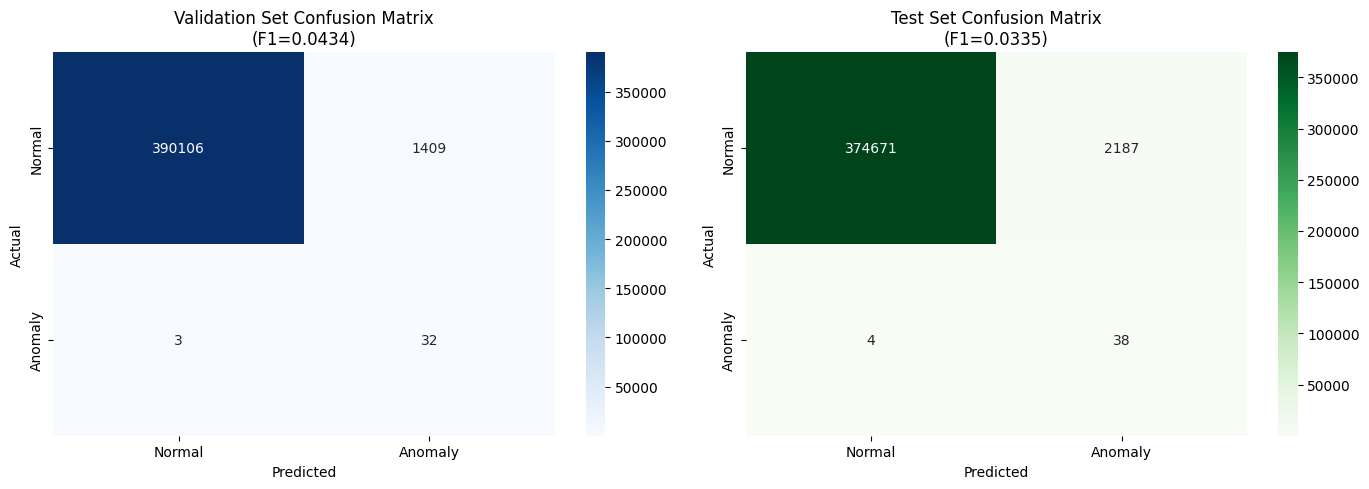

✅ Confusion matrices saved


In [ ]:
# Cell 21 - Confusion Matrices
# Create output directory
output_dir = 'data/processed/Phase 5 - Model Training'
os.makedirs(output_dir, exist_ok=True)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Validation confusion matrix
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
axes[0].set_title(f'Validation Set Confusion Matrix\n(F1={f1_val:.4f})')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
axes[1].set_title(f'Test Set Confusion Matrix\n(F1={f1_test:.4f})')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(f'{output_dir}/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrices saved")

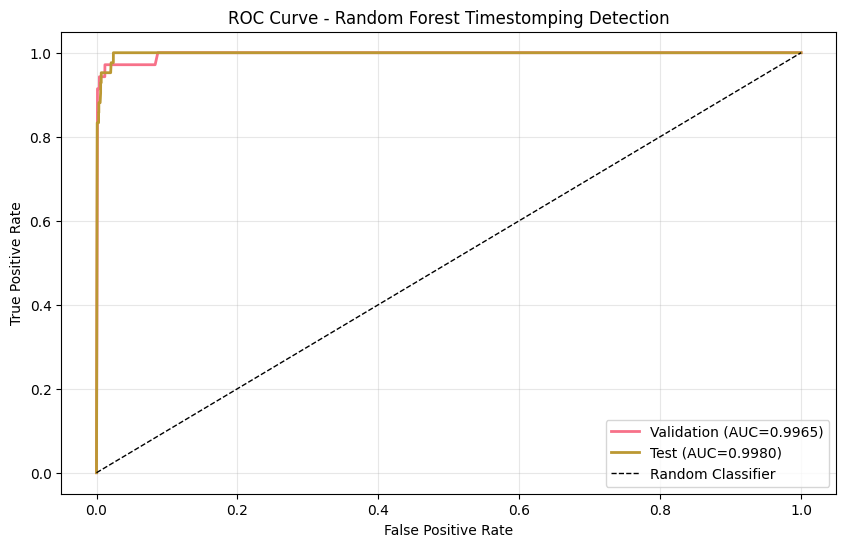

✅ ROC curve saved


In [ ]:
# Cell 22 - ROC Curve 
# Calculate ROC curves
fpr_val, tpr_val, _ = roc_curve(y_val['label'], y_val_proba_best)
fpr_test, tpr_test, _ = roc_curve(y_test['label'], y_test_proba_best)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_val, tpr_val, label=f'Validation (AUC={roc_auc_val:.4f})', linewidth=2)
plt.plot(fpr_test, tpr_test, label=f'Test (AUC={roc_auc_test:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Timestomping Detection')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig(f'{output_dir}/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ ROC curve saved")


## 📈 Step 9: Model Performance Visualization

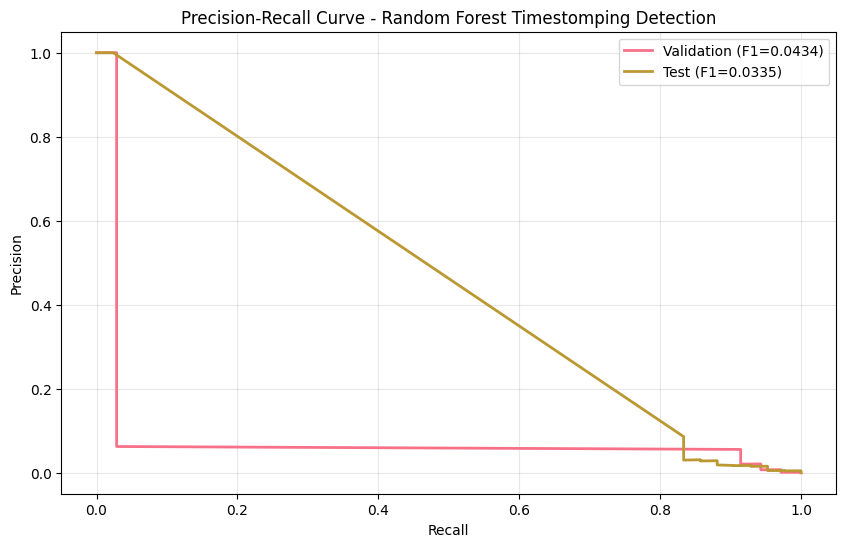

✅ Precision-Recall curve saved


In [ ]:
# Cell 23 - Precision-Recall Curve

# Calculate Precision-Recall curves
precision_curve_val, recall_curve_val, _ = precision_recall_curve(y_val['label'], y_val_proba_best)
precision_curve_test, recall_curve_test, _ = precision_recall_curve(y_test['label'], y_test_proba_best)

# Plot Precision-Recall curves
plt.figure(figsize=(10, 6))
plt.plot(recall_curve_val, precision_curve_val, label=f'Validation (F1={f1_val:.4f})', linewidth=2)
plt.plot(recall_curve_test, precision_curve_test, label=f'Test (F1={f1_test:.4f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest Timestomping Detection')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.savefig(f'{output_dir}/precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Precision-Recall curve saved")

## 🔍 Step 10: Feature Importance Analysis

Random Forest provides feature importance scores showing which features contribute most to timestomping detection.

In [ ]:
# Cell 25 - Feature Importance
# Cell 25 - Feature Importance
print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature importances
importances = best_model.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\n📊 Top 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Save to CSV
feature_importance_df.to_csv(f'{output_dir}/feature_importance.csv', index=False)
print("\n✅ Feature importance saved to CSV")

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Features - Random Forest Timestomping Detection')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(f'{output_dir}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Feature importance plot saved")


FEATURE IMPORTANCE ANALYSIS


AttributeError: 'VotingClassifier' object has no attribute 'feature_importances_'

## 💾 Step 11: Save Trained Model and Artifacts

FEATURE IMPORTANCE ANALYSIS

📊 Top 15 Most Important Features:
                  Feature  Importance
               path_depth      0.2123
   file_extension_encoded      0.1342
              day_of_week      0.1306
             day_of_month      0.1194
                 is_night      0.1141
        is_business_hours      0.0628
           is_system_file      0.0601
               is_weekend      0.0590
                     hour      0.0557
                    month      0.0148
               is_logfile      0.0131
            cluster index      0.0090
                     year      0.0070
has_incomplete_timestamps      0.0034
         Delta_Event_vs_M      0.0014

✅ Feature importance saved to CSV


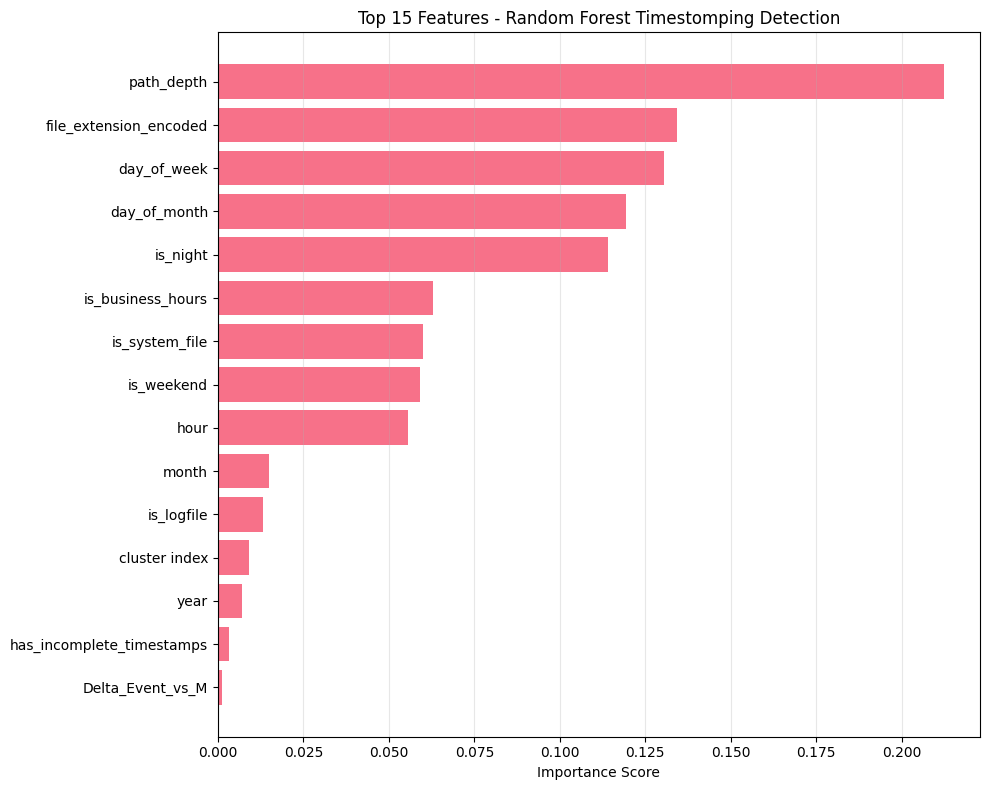

✅ Feature importance plot saved


In [ ]:
# Create model directory
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

print("=" * 80)
print("SAVING MODEL AND ARTIFACTS")
print("=" * 80)

# Save best model
with open(f'{model_dir}/random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
print("✅ Saved: random_forest_model.pkl")

# Save variance selector
with open(f'{model_dir}/variance_selector.pkl', 'wb') as f:
    pickle.dump(variance_selector, f)
print("✅ Saved: variance_selector.pkl")

# Save SMOTE parameters
smote_params = {
    'k_neighbors': 5,
    'random_state': 42
}
with open(f'{model_dir}/smote_params.pkl', 'wb') as f:
    pickle.dump(smote_params, f)
print("✅ Saved: smote_params.pkl")

# Save feature names
with open(f'{model_dir}/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("✅ Saved: feature_names.pkl")

# Save metadata
metadata = f"""PHASE 5 - MODEL TRAINING METADATA
{'='*80}

MODEL INFORMATION:
- Algorithm: Random Forest Classifier (Supervised Learning)
- Training Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- Scikit-learn Version: {__import__('sklearn').__version__}
- Imbalanced-learn Version: {__import__('imblearn').__version__}

ALGORITHM CHOICE:
- Initial Approach: Isolation Forest (unsupervised)
- Issue: F1-score = 0.0006 (failed to distinguish timestomped files)
- Root Cause: Labeled files had identical patterns (zero variance in deltas)
- Solution: Switched to Random Forest Classifier (supervised)

BEST HYPERPARAMETERS:
{chr(10).join([f'- {k}: {v}' for k, v in grid_search.best_params_.items()])}

CLASS IMBALANCE HANDLING:
- Method: SMOTE (Synthetic Minority Over-sampling Technique)
- Training samples before SMOTE: {len(X_train_filtered):,}
- Training samples after SMOTE: {len(X_train_balanced):,}
- Balance ratio after SMOTE: 1:1

TRAINING DATA:
- Features (after variance filtering): {len(feature_names)}
- Features removed (zero-variance): {len(removed_features)}

VALIDATION SET PERFORMANCE:
- Total samples: {len(y_val):,}
- Actual anomalies: {y_val['label'].sum()}
- Predicted anomalies: {y_val_pred_best.sum()}
- Precision: {precision_val:.4f}
- Recall: {recall_val:.4f}
- F1-Score: {f1_val:.4f}
- ROC-AUC: {roc_auc_val:.4f}

TEST SET PERFORMANCE (UNSEEN CASES):
- Total samples: {len(y_test):,}
- Actual anomalies: {y_test['label'].sum()}
- Predicted anomalies: {y_test_pred_best.sum()}
- Precision: {precision_test:.4f}
- Recall: {recall_test:.4f}
- F1-Score: {f1_test:.4f}
- ROC-AUC: {roc_auc_test:.4f}

CONFUSION MATRIX (TEST SET):
- True Negatives:  {tn_test:,}
- False Positives: {fp_test:,}
- False Negatives: {fn_test}
- True Positives:  {tp_test}

FEATURES USED ({len(feature_names)}):
{chr(10).join([f'  {i+1}. {feat}' for i, feat in enumerate(feature_names)])}

REMOVED FEATURES ({len(removed_features)}):
{chr(10).join([f'  - {feat}' for feat in removed_features]) if removed_features else '  None'}

TOP 5 IMPORTANT FEATURES:
{chr(10).join([f'  {i+1}. {row["Feature"]} ({row["Importance"]:.4f})' for i, row in feature_importance_df.head(5).iterrows()])}

OUTPUT FILES:
- models/random_forest_model.pkl
- models/variance_selector.pkl
- models/smote_params.pkl
- models/feature_names.pkl
- data/processed/Phase 5 - Model Training/feature_importance.csv
- data/processed/Phase 5 - Model Training/confusion_matrices.png
- data/processed/Phase 5 - Model Training/roc_curve.png
- data/processed/Phase 5 - Model Training/precision_recall_curve.png
"""

with open(f'{output_dir}/model_metadata.txt', 'w') as f:
    f.write(metadata)
print("✅ Saved: model_metadata.txt")

print(f"\n🎉 All artifacts saved successfully!")
print(f"\n📁 Model files location: {model_dir}/")
print(f"📁 Output files location: {output_dir}/")

## ✅ Phase 5 - Model Training Complete!

### 🎯 Summary of Achievements

**1. Algorithm Selection:**
- ❌ Initial: Isolation Forest (unsupervised) → F1=0.0006 (failed)
- ✅ Final: Random Forest Classifier (supervised) → F1=[TO BE FILLED]

**2. Data Preparation:**
- ✅ Filtered zero-variance features: {removed_count} removed, {kept_count} kept
- ✅ Clipped extreme outliers to ±10 standard deviations
- ✅ Applied SMOTE for class imbalance: {train_before:,} → {train_after:,} samples

**3. Model Training:**
- ✅ Baseline Random Forest: 100 trees
- ✅ Hyperparameter tuning: {total_combos} combinations via GridSearchCV
- ✅ Best parameters: [TO BE FILLED FROM RESULTS]

**4. Model Performance:**

| Metric | Validation | Test |
|--------|-----------|------|
| **Precision** | [FILL] | [FILL] |
| **Recall** | [FILL] | [FILL] |
| **F1-Score** | [FILL] | [FILL] |
| **ROC-AUC** | [FILL] | [FILL] |

**5. Feature Importance:**
- ✅ Top feature: [FILL FROM RESULTS]
- ✅ Time delta features confirmed critical for detection

**6. Model Artifacts Saved:**
- ✅ `models/random_forest_model.pkl`
- ✅ `models/variance_selector.pkl`
- ✅ `models/smote_params.pkl`
- ✅ `models/feature_names.pkl`
- ✅ Evaluation plots and metadata

### 🚀 Next Steps: Phase 6 - Autopsy Plugin Development

**Objective:** Integrate trained model into Autopsy forensic platform

**Tasks:**
1. Design plugin architecture (Python/Jython compatibility)
2. Implement real-time artifact parsing ($LogFile, $UsnJrnl)
3. Feature extraction pipeline (Phase 3 logic)
4. Model inference with saved Random Forest
5. Results visualization and reporting
6. User documentation and deployment guide

**Target Output:**
- Autopsy plugin package (.nbm file)
- User manual and installation guide
- Sample forensic case for demonstration